4.5

機械学習応用で最重要：
 1. 特徴量選択
 2. 特徴量と機械学習手法との組み合わせ

特徴量の選択戦略 （全て教師あり）（特徴量選択には訓練セットだけ用いる）：
 1. 単変量統計　（モデル不使用）
 2. モデルベース選択　（モデル1つ使用）
 3. 反復選択　（モデル複数使用）


4.5.1

単変量統計:
 - 特徴量とターゲット間の統計的関係を求め、信頼度が最も高い特徴量を採用。
 - クラス分類でいう分散分析（ANOVA:Analysis of Variance)
 - 単変量：個々の特徴量を個別に考慮：他の特徴量と組み合わせて意味を持つものは捨てられる。
 - テストを選択：
  1. クラス分類： f_classif　（デフォルト値）
  2. 回帰： f_regression
 - テストで求められるp-値を元に、特徴量を捨てる方法も指定（p-値が過大（yと無関係）な特徴量を捨てる閾値指定）
 - 閾値計算方法： 
  1. SelectKBest　（選択する特徴量数を指定。最も単純。）
  2. SelectPercentile (残す特徴量の割合を選択）

 

特徴量抽出（cancer、クラス分類）

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
%matplotlib inline

In [9]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

d = load_breast_cancer()
x,y = d.data, d.target

r = np.random.RandomState(42)
n = r.normal(size=(len(x), 50))

xn = np.hstack([x,n]) # 最初の30特徴量：データセットから、後の50特徴量はノイズ

ax,ex,ay,ey = train_test_split(xn,y,random_state=0,test_size=.5)
s = SelectPercentile(percentile=50) # 50%の特徴量を選択
s.fit(ax,ay)

axs = s.transform(ax)
ax.shape

(284, 80)

In [10]:
axs.shape

(284, 40)

-> 特徴量が80から40に減少（選別）。選択した特徴量：

In [17]:
# 選択した特徴量
b = s.get_support()
b

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True, False,  True,
       False, False,  True, False, False, False, False,  True, False,
       False,  True, False, False,  True, False,  True, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False,  True, False,  True, False, False, False, False,
        True,  True, False,  True, False, False, False, False])

In [18]:
b.shape

(80,)

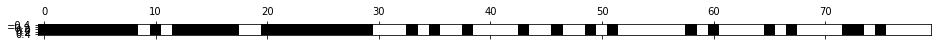

In [19]:
# 選択是非をプロット
plt.matshow(b.reshape(1,-1), cmap='gray_r'); # cmap='gray_r'

-> 前半の特徴量（30/80)のほとんどが選択されている

In [22]:
# ロジスティック回帰で性能比較　（全特徴量の場合と選択された特徴量の場合）
# 全特徴量のスコア(80個)
from sklearn.linear_model import LogisticRegression
exs  = s.transform(ex)
m = LogisticRegression()
m.fit(ax,ay)
m.score(ex,ey) 

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9298245614035088

In [23]:
# 単変量特徴量選択によるスコア(40個)
m.fit(axs, ay)
m.score(exs,ey)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9403508771929825

-> 特徴量を選別した方が性能良くなった（92% -> 94%）

4.5.2
モデルベース特徴量選択：
 - 教師あり学習モデルで個々の特徴量の重要性を判断し、重要なものだけ残す手法
 - そのモデルは最終的に使うモデルと異なっても良い
 - モデルは特徴量の重要性の指標を出力するものを用いる（決定系など）
 - 重要性を表す指標（例）：
  - 線形モデルの係数の絶対値
  - 決定木系のfeature_importances_
 - L1ペナルティの線形モデル： 疎な係数を学習 （=特徴量の一部だけ使用） -> これを特徴量選択に使用可能
 - 全ての特徴量を同時に考慮　＝　変数間の交互作用がわかる
 - SelectFromModel変換器を使用
 - 特徴量の重要度が、指定した閾値より大きい特徴量だけ選択


モデルベース特徴量選択：

In [30]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
s = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median") # 内部の決定木数：100
s.fit(ax,ay)
ax1 = s.transform(ax)
print(ax.shape)
print(ax1.shape)

(284, 80)
(284, 40)


-> 特徴量数が半分に減少（80->40)

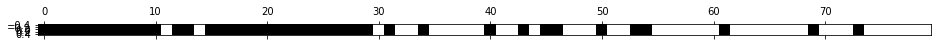

In [33]:
# 採用された特徴量をプロット
b = s.get_support()
plt.matshow(b.reshape(1,-1), cmap='gray_r');

-> 黒が採用された特徴量。約半分が採用されていることがわかる。

In [36]:
# モデルベース特徴量選択によるスコア(40個選択)
ex1 = s.transform(ex)
LogisticRegression().fit(ax1,ay).score(ex1,ey)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9508771929824561

-> 性能向上している（重要度の高い特徴量の選択による）

4.5.3 反復特徴量選択
 - 異なる特徴量を用いた一連のモデルを作成　（→計算コスト大）
 - 特徴量の重要度を表示できるモデルを使用すること
 - 手法：
  1. 特徴量を増やす（ゼロから1つずつ、基準満たすまで増やす）
  2. 特徴量を減らす（全て使用している状態から）
    - 再帰的特徴量削減 (RFE: Recursive Feature Elimination)
       1. 全ての特徴量からモデルを作り、そのモデルから最も重要度の低い特徴量を削除
       2. 残りの特徴量からモデルを作り、そのモデルから最も重要度の低い特徴量を削除
       3. 基準を満たすまで上記を繰り返し
